<b>Exercise and Non-Exercise Predictors of Heart Disease</b>

Heart disease (HD) has many symptoms, thus, diagnosis is difficult, and it is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). Our question is: Can exercise-related parameters more accurately diagnose HD than non-exercise-related predictors? We will create one model classifying non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression during exercise, angina during exercise, and slope (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0-4 (Detrano, n.d.).

In [119]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [120]:
# Installation of the required libraries to conduct our data analysis. Setting of the seed to ensure our analysis is reproducible (Detrano, n.d.).
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)
set.seed(9999)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [121]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<b>WRANGLING THE DATA:</b>

In [122]:
# Set the dataset's column names to the variable descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

In [123]:
# Mutate the result column into a factor, so it can be used to color and fill the graphs.
cleveland_data <- mutate(cleveland_data, result = as_factor(result))

# Wrangling the data by creating the desired datasets.
# First Dataset: data collected from patients in the non-exercise state.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Second Dataset: data collected from patients after exercise.
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

In [124]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.
cleveland_data_resting_mean <- cleveland_data_resting |>
    select(age:resting_electrocardio) |>
    map_df(mean)
cleveland_data_resting_mean

age,resting_blood_pressure,resting_electrocardio
<dbl>,<dbl>,<dbl>
54.43894,131.6898,0.990099


<b>Table 1:</b> Mean value of the non-exercise predictors.

In [125]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.

cleveland_data_exercise_mean <- cleveland_data_exercise |>
    select(exercise_angina:exercise_slope) |>
    map_df(mean)
cleveland_data_exercise_mean

exercise_angina,exercise_st,exercise_slope
<dbl>,<dbl>,<dbl>
0.3267327,1.039604,1.60066


<b>Table 2:</b> Mean value the exercise predictors.  

We wrangled the data to create our datasets from the processed.cleveland.data (Detrano, n.d.). Our first dataset includes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as in many experiments its correlation to HD has been identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of the most important risk factors for cardiovascular disease” (Wu et al., 2015). Our second dataset includes exercise-related predictors. ST depression during exercise is used as it is related to HD outcome, thus having medical value (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study the involvement of exercise testing for HD predictions, correlating to the extent of illness (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis (Detrano, n.d.).

As an initial visualization, we looked at each variable’s means (Tables 1 and 2) to understand their ranges. Their means are not on the same scale within a single dataset, indicating that we are required to scale them for modeling.

<b>SPLITTING THE DATA INTO TRAINING AND TESTING:</b>

We will perform a $K$-nearest neighbors classification, using tidymodels, thus we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data to build accurate models. 

In [126]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.
set.seed(9999)

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

<b>VISUALIZING THE DATA:</b>

Our preliminary visualizations are histograms as our predictors are either binary or adopt a range of values. The predictors’ values are on the x-axis and diagnoses, from 0 (no HD) to 4 (severe HD) are on the y-axis.

<b>GROUP 1 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



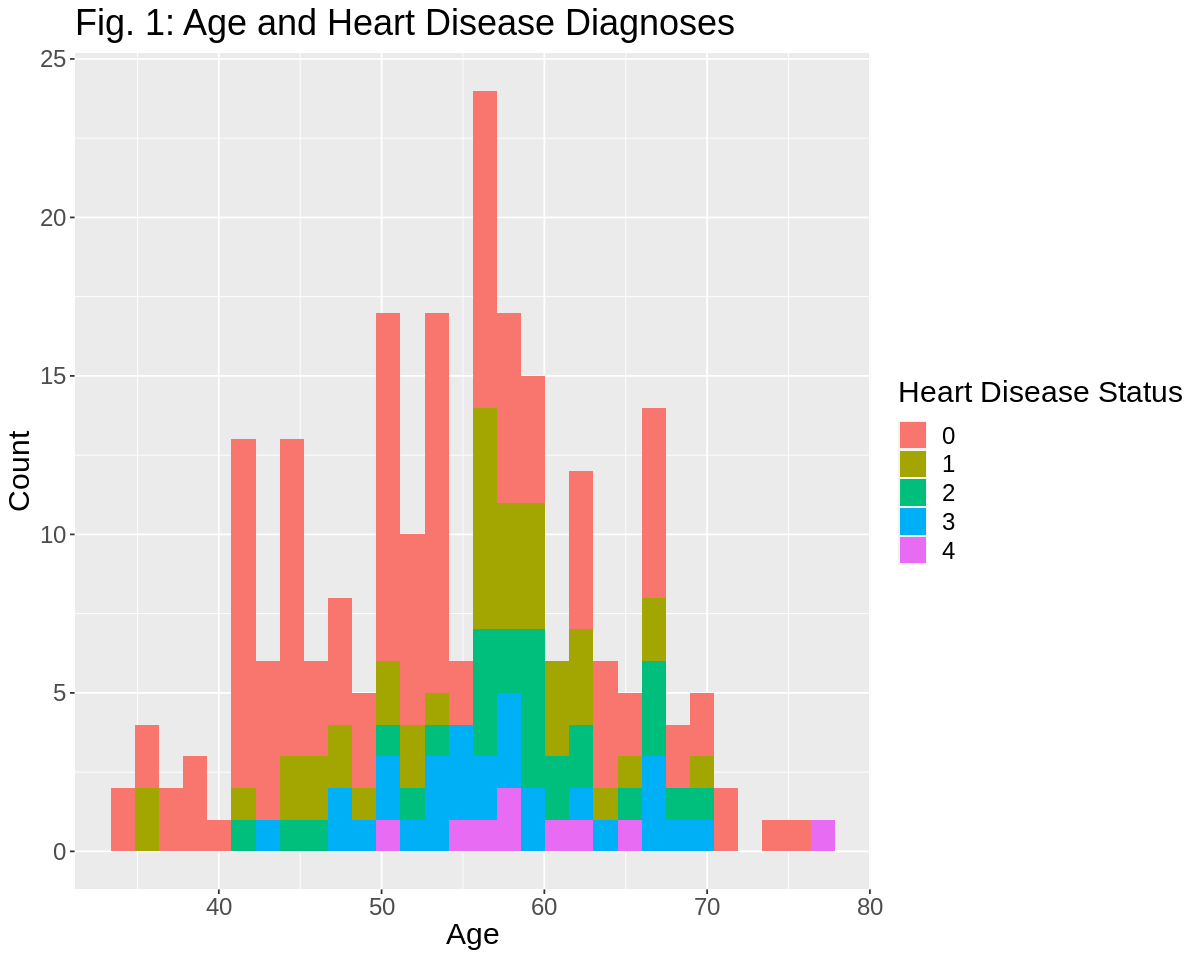

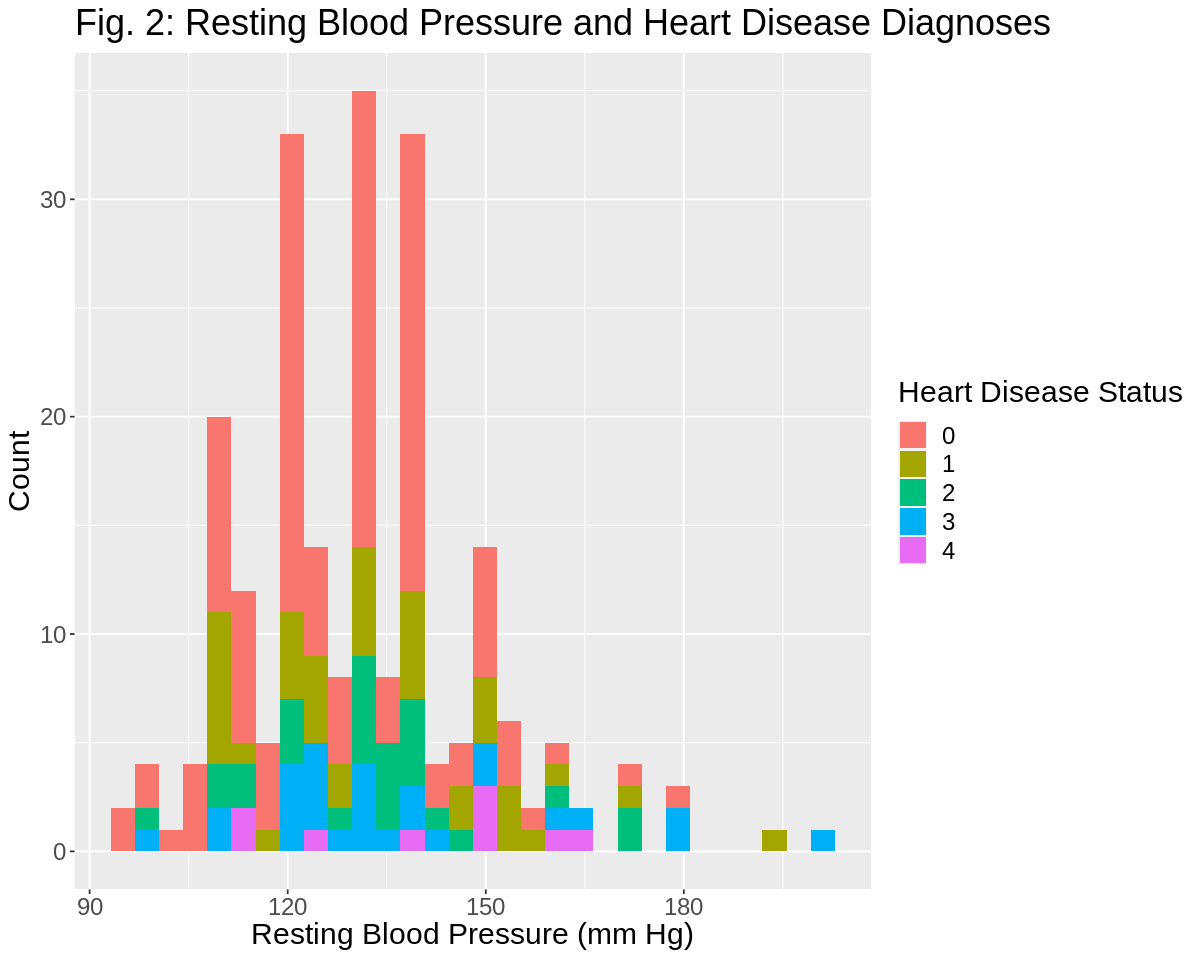

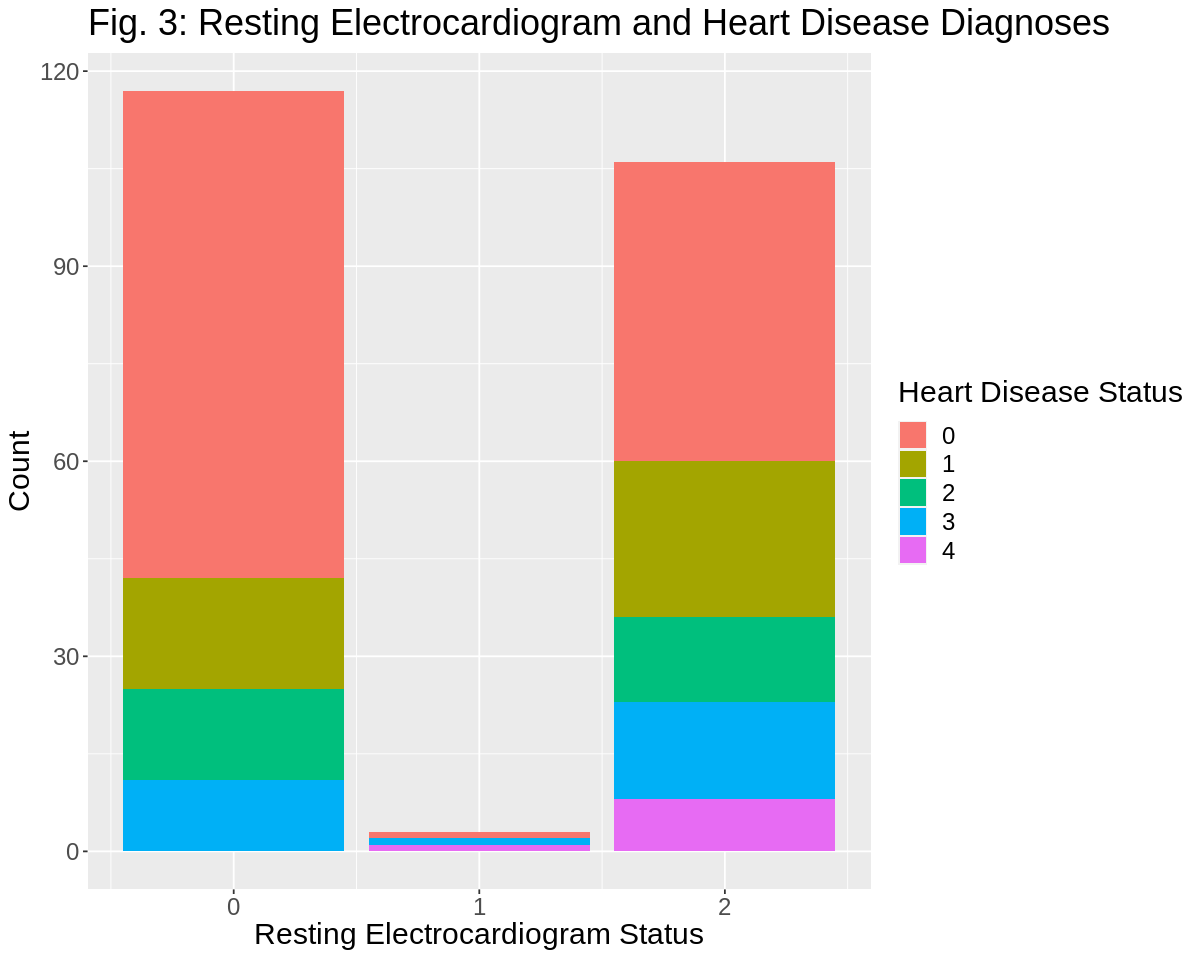

In [127]:
#Creating the plots to visualize the predictors from the first dataset in relation to the severity of heart disease. 
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
resting_age_plot

resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
resting_bps_plot

resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
    ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Resting Electrocardiogram Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
resting_electro_plot

These depict the predictors’ distribution, indicating how HD diagnosis is associated with each predictor value. In Figure 1, ages are between 5 and 75, while most data are concentrated around ages 50-65. In our training data, there will be more of this range of ages than any other, thus these will affect our model most. In Figure 2, there is a range of resting blood pressure ~95-205 mmHg, with most concentrated 105-150 mmHg. A large portion of these data are not associated with a HD diagnosis. Finally, looking at Figure 3, most observations are assigned as either 0 or 2. When it is 0, more than half the observations are diagnosed as not having HD. However, when it is assigned 2, each diagnostic severity occurs. These demonstrate the association between our predictors’ values and HD diagnosis. Graphically analyzing the predictor range emphasizes the importance of scaling the data for modeling. 

<b>GROUP 2 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



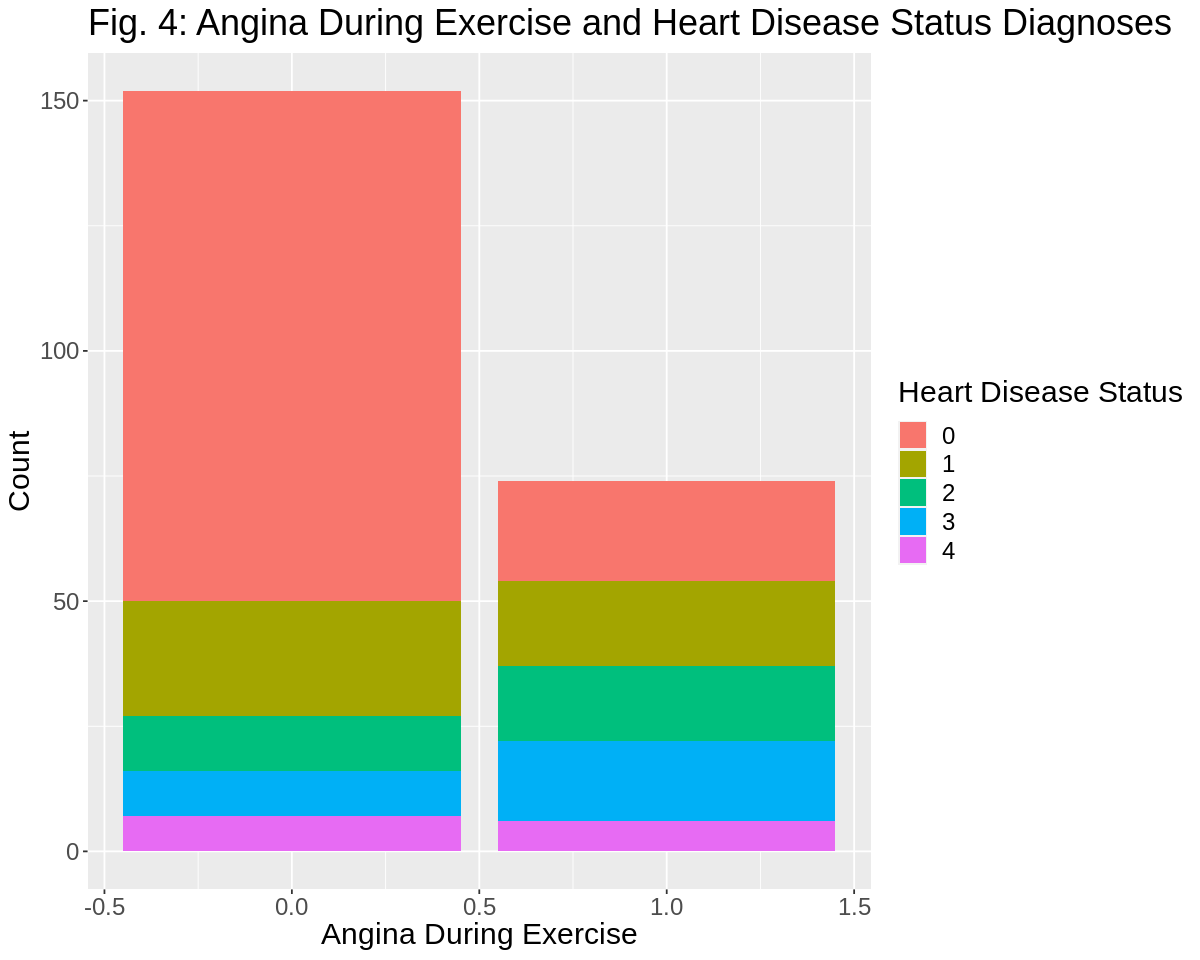

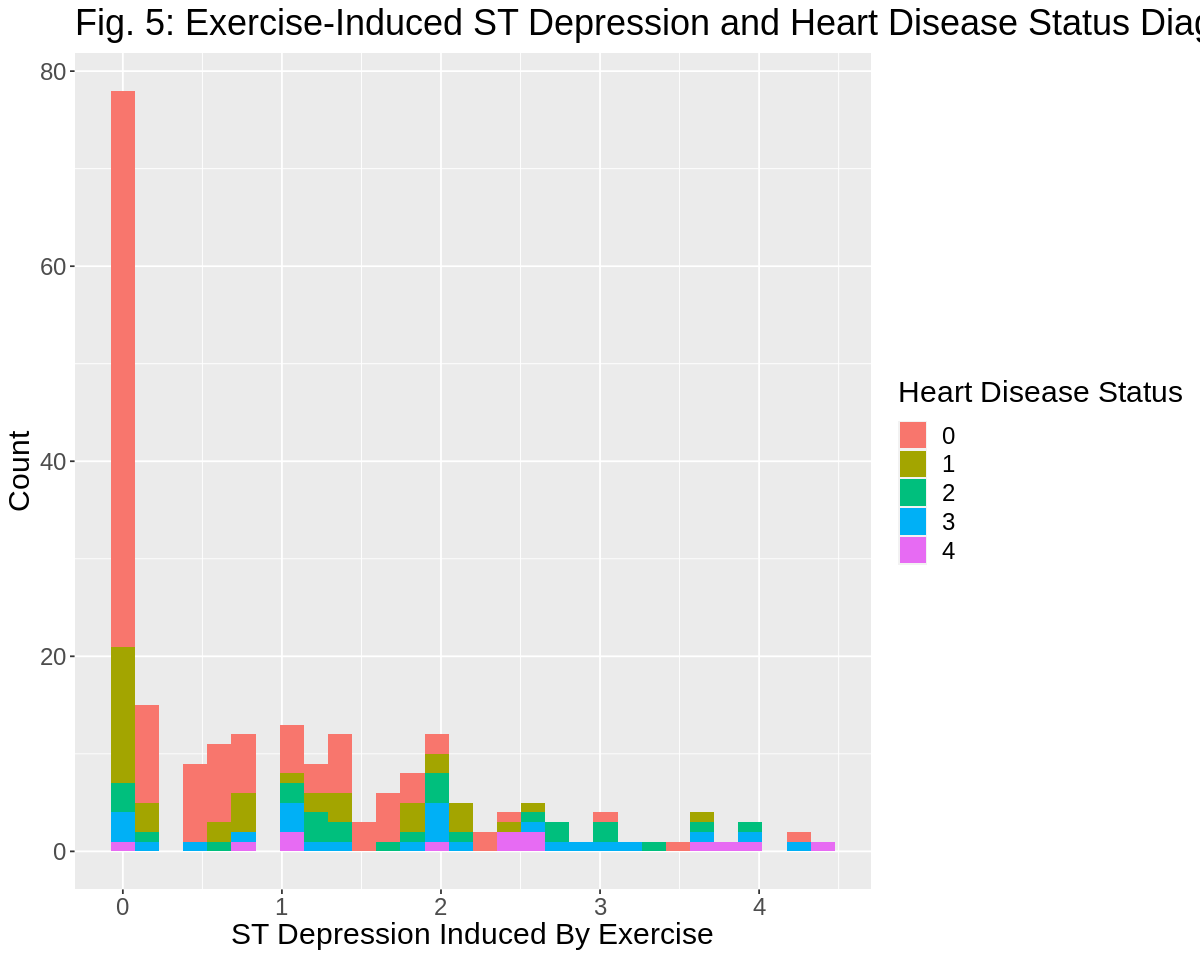

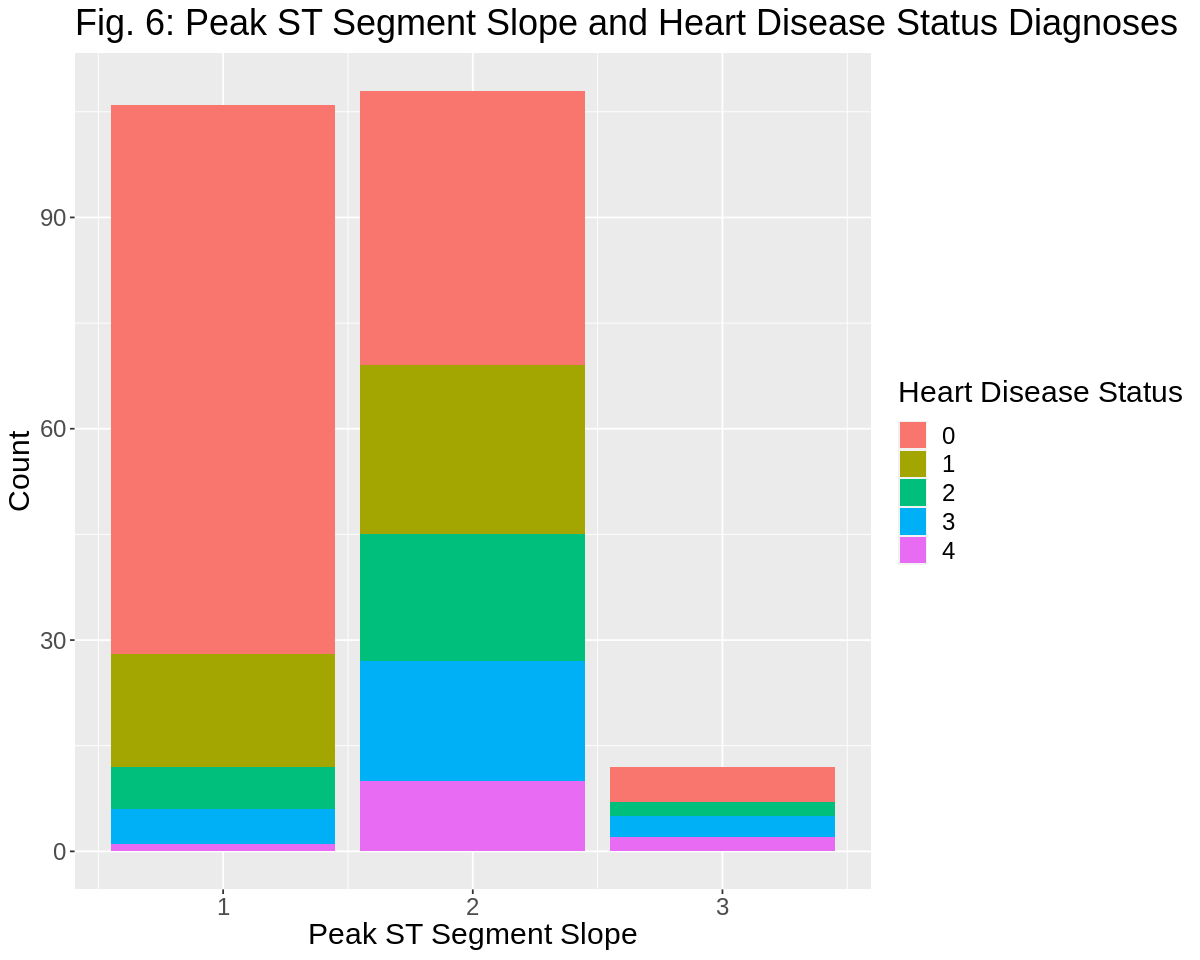

In [128]:
#Creating the plots to visualize the predictors in the second data set in relation to the severity of heart disease.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

exercise_angina <- ggplot(exercise_train, aes(x = exercise_angina)) +
    ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
exercise_angina

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +

    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("ST Depression Induced By Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
exercise_st_plot

exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Peak ST Segment Slope and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Peak ST Segment Slope") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 18))
exercise_slope_plot

These histograms demonstrate the association between our exercise predictors and HD diagnosis. In Figure 4, we see that exercise angina is a binary predictor, associated with values 0 or 1. More observations have a value of 0 than of 1. A large portion of those with angina of 0 have a no HD diagnosis. With an angina of 1, each diagnosis is roughly evenly represented. Figure 5 depicts the distribution of the ST depression induced by exercise, which holds values between 0 and 4.5. The largest proportion is at 0, and the majority have no HD diagnosis. With increasing ST depression, more HD diagnoses occur. Finally, in Figure 6, the peak ST segment slope adopts values of 1, 2, or 3. Most observations are at values of 1 or 2, and the number of individuals with no HD diagnosis decreases as the predictor’s value increases. These graphs expose our data’s range, allowing us to make some preliminary predictions about their associated HD diagnosis.

<b>NON-EXERCISE PREDICTORS MODELLING:</b>

Our first model predicts HD diagnosis using predictors that are independent of exercise. These include age, resting blood pressure, and resting electrocardiogram. This model’s accuracy with the testing data will allow us to determine whether a diagnostic paradigm for HD including these variables will be sufficient for HD diagnosis. 

We need to determine the number of each diagnosis in our training data to determine if the classes are balanced.

In [129]:
# Determining the number of observations of each result to determine if we need to balance the classes.

number_of_each_result_resting <- resting_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_resting

result,count
<fct>,<int>
0,122
1,41
2,27
3,27
4,9


<b>Table 3:</b> The number of each result in our dataset indicates the classes are not balanced, there are significantly more diagnoses at 0 than in the other classes, thus we will have to balance the classes in our model. We have to create a balanced dataset to use in the modeling.

In [130]:
set.seed(9999)

# Creating a recipe to upsample the data so that we balance the classes. 
balanced_recipe_resting <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = resting_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_resting_train <- bake(balanced_recipe_resting, resting_train)

Now we are creating a recipe, indicating that we are classifying with respect to the result variable, using our three non-exercise predictors. This scales and centers the data, so that all predictors are on the same scale. This eliminates the possibility of a single predictor having a larger effect on the model, due to its wider range. 

In [131]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

resting_recipe <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = balanced_resting_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

We are now specifying a classification model, indicating that we are tuning the number of neighbours. This will allow us to find a K value with optimal accuracy. 


In [132]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

resting_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

Part of tuning the model is doing a cross-validation analysis. This uses the training dataset to training the model on a portion of it, and testing this model on the validation set, giving us an estimate of the K values’ accuracy, specified to try using the tibble. These are included in the workflow to determine the accuracy. 


In [133]:
set.seed(9999)

# Creating a cross validation set. 

resting_vfold <- vfold_cv(resting_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 2))
                   
# Creating a workflow to determine the best K. 

resting_model_workflow <- workflow() |>
                            add_recipe(resting_recipe) |>
                            add_model(resting_model_tune) |>
                            tune_grid(resamples = resting_vfold, grid = k_to_try) |>
                            collect_metrics()

! Fold03: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold09: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



We plot the K value accuracy from the tune grid, to determine a K with high accuracy whose adjacent values are also accurate. 

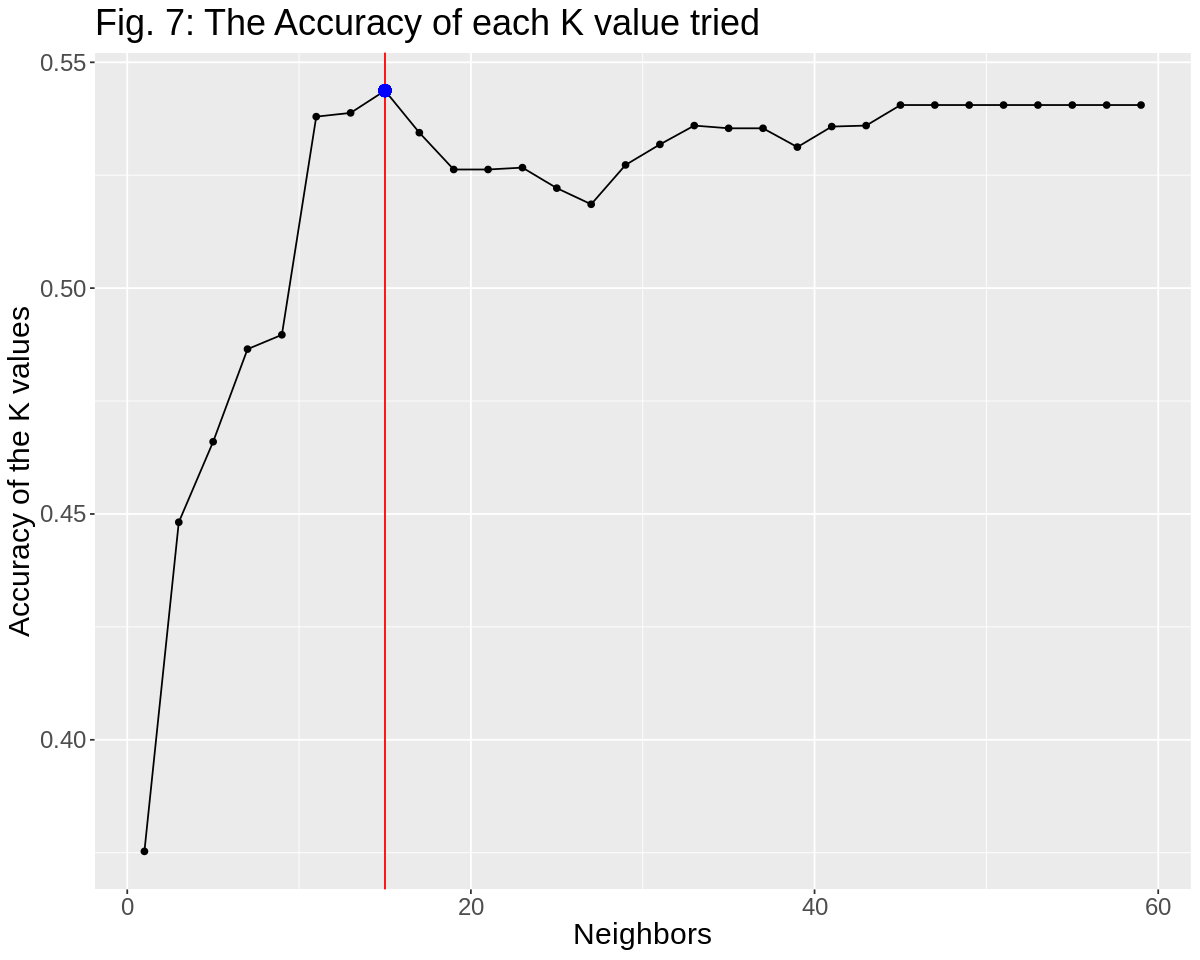

In [134]:
# Filtering the accuracy of each K from the metrics.

accuracy_of_k <- resting_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy_k <- accuracy_of_k|>
                filter(neighbors == 15) |> 
                select(mean) |>
                pull()

accuracy_plot <- accuracy_of_k |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 15, colour = "red") +
                    geom_point(aes(x = 15, y = highest_accuracy_k), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 7: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 18))

accuracy_plot

From the above plot, we will choose $K$ = 15 to build this model. This is because this $K$ generates the highest accuracy, while still having the K values adjacent to it being relatively accurate as well. 

With the best K, we create a new model, indicating this value as the number of neighbours. We can then establish a new fit, with this model and the above resting_train, to our training data. This allows the model to be trained, without seeing the testing data, thus we can obtain a good accuracy estimate for the model. Finally, we can predict the testing data’s labels. 


In [135]:
set.seed(9999)

# Creating a new model which includes the K to generate the best fit. 

best_resting_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_resting_fit <- workflow() |>
                        add_recipe(resting_recipe) |>
                        add_model(best_resting_model) |>
                        fit(data = balanced_resting_train)

# Fitting the model to our testing data to make the predictions. 

resting_predictions <- best_resting_fit |>
                        predict(resting_test) |>
                        bind_cols(resting_test)

In [136]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

resting_metrics <- resting_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
resting_metrics

resting_conf_mat <- resting_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
resting_conf_mat

[1] 0.2467532

          Truth
Prediction  0  1  2  3  4
         0 12  3  2  2  1
         1  5  2  2  2  1
         2 12  6  3  1  0
         3  6  1  0  1  1
         4  7  2  2  2  1

<b>Table 4:</b> Our resting model provides an accuracy of ~0.25, thus it only predicts the diagnosis accurately 25% of the time. From the confusion matrix, we know it recognizes and makes predictions for all results, yet the low accuracy makes the model challenging to apply.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



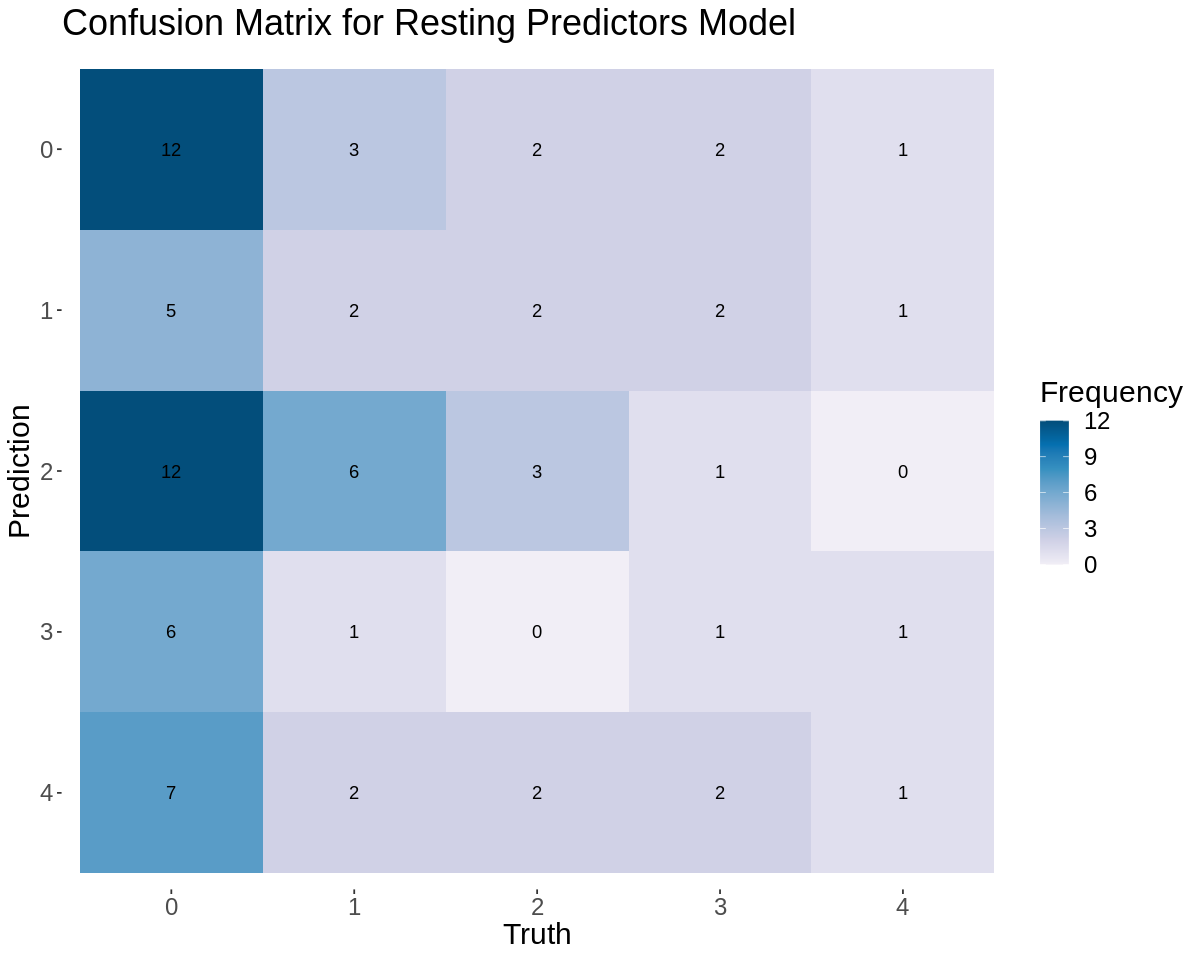

In [137]:
#visualizing the confusion matrix for the resting predictors model

autoplot(resting_conf_mat, type = "heatmap") +
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +        
    labs(title = "Confusion Matrix for Resting Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 18),
          plot.caption = element_text(size = 16, hjust = 0))

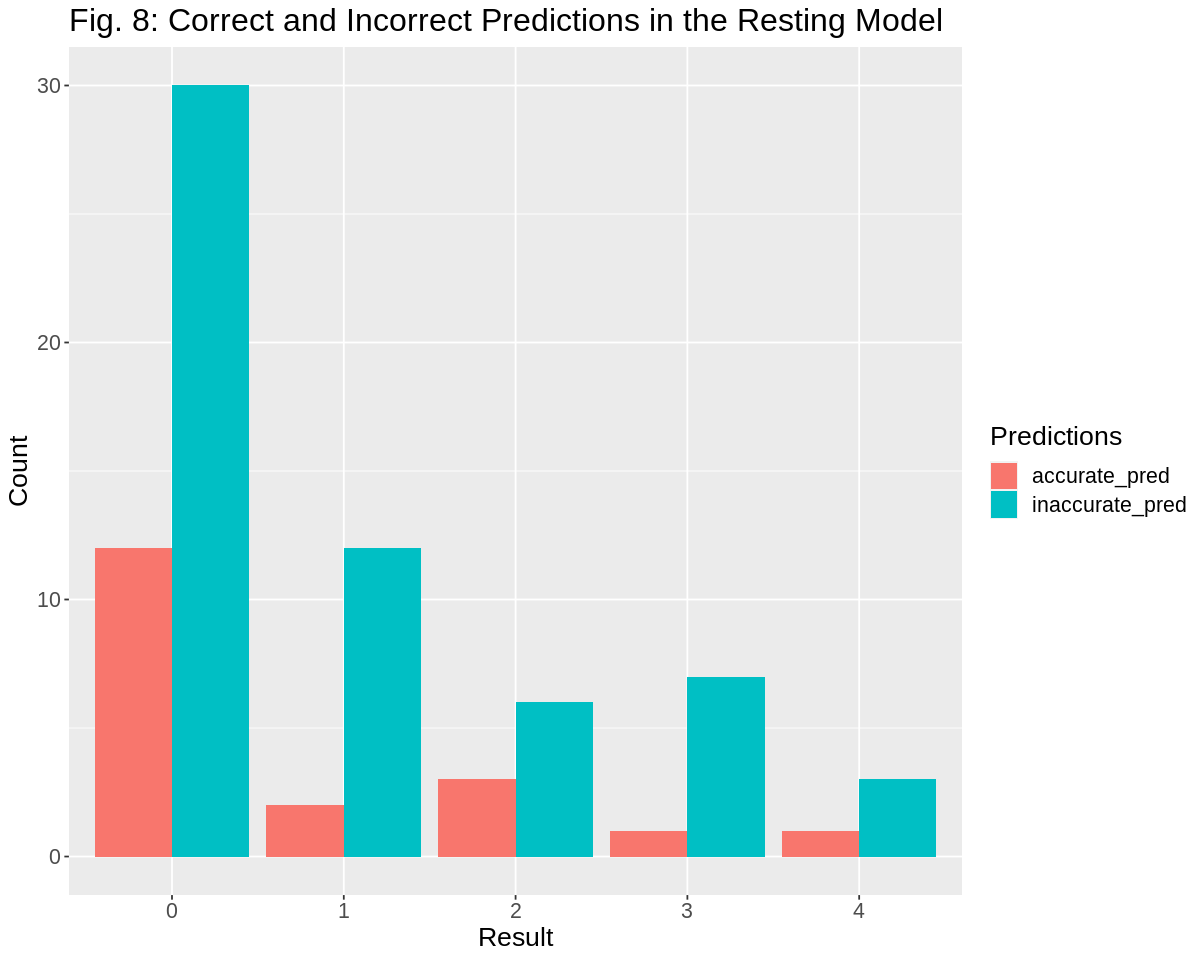

In [138]:
# Making the confusion matrix into a data frame.

resting_pred_accuracy <- resting_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result))
    data_long <- reshape2::melt(resting_pred_accuracy, id.vars = "result")

# Visualizing the confusion matrix as a bar graph. 

resting_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 8: Correct and Incorrect Predictions in the Resting Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

resting_pred_accuracy_plot

This bar graph demonstrates the number of correct predictions made by our model, compared to the number of incorrect predictions, for each result. This emphasizes the challenges that our model has with accurate predictions. With each result, there are more incorrect than correct predictions, which shows that we need to investigate its accuracy further and determine why this is occurring. 

<b>EXERCISE PREDICTORS MODELLING</b>

The next model we are making is for our exercise predictors, including exercise-induced angina, ST depression with exercise, and slope during exercise. This will be used to predict the HD diagnosis.

We need to determine whether the classes are balanced to be able to modify the dataset if needed before modeling.  

In [139]:
# Checking the amount of each of the results in our training set to determine if we have to balance the classes.
number_of_each_result_exercise <- exercise_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_exercise

result,count
<fct>,<int>
0,122
1,40
2,26
3,25
4,13


<b>Table 5:</b> The number of each result in the training dataset indicates the classes are not balanced , there is a lot more of the 0 result than any other, thus we created a balanced dataset.

In [140]:
# Creating a recipe to upsample the data so that we balance the classes. 
balanced_recipe_exercise <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_exercise_train <- bake(balanced_recipe_exercise, exercise_train)

Now, we will create a recipe, that scales and centers the data so that all predictors have the same scale, and thus contribute equally to the model. This recipe indicates that we are predicting for the result variable. 

In [141]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

exercise_recipe <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

In [142]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

exercise_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

We are performing cross-validation and using tune grid to find the best K value to use in this model. This allows us to determine the accuracy of each K we try by testing it on portions of the training set called validation sets. 

In [143]:
set.seed(9999)

# Creating a cross validation set. 

exercise_vfold <- vfold_cv(exercise_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 2))
                   
# Creating a workflow to determine the best K. 

exercise_model_workflow <- workflow() |>
                            add_recipe(exercise_recipe) |>
                            add_model(exercise_model_tune) |>
                            tune_grid(resamples = exercise_vfold, grid = k_to_try) |>
                            collect_metrics()

! Fold03: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



Now that we have completed cross-validation we need to determine the best K, thus by plotting all the K tried with respect to their accuracy, we can determine the best K to use. 

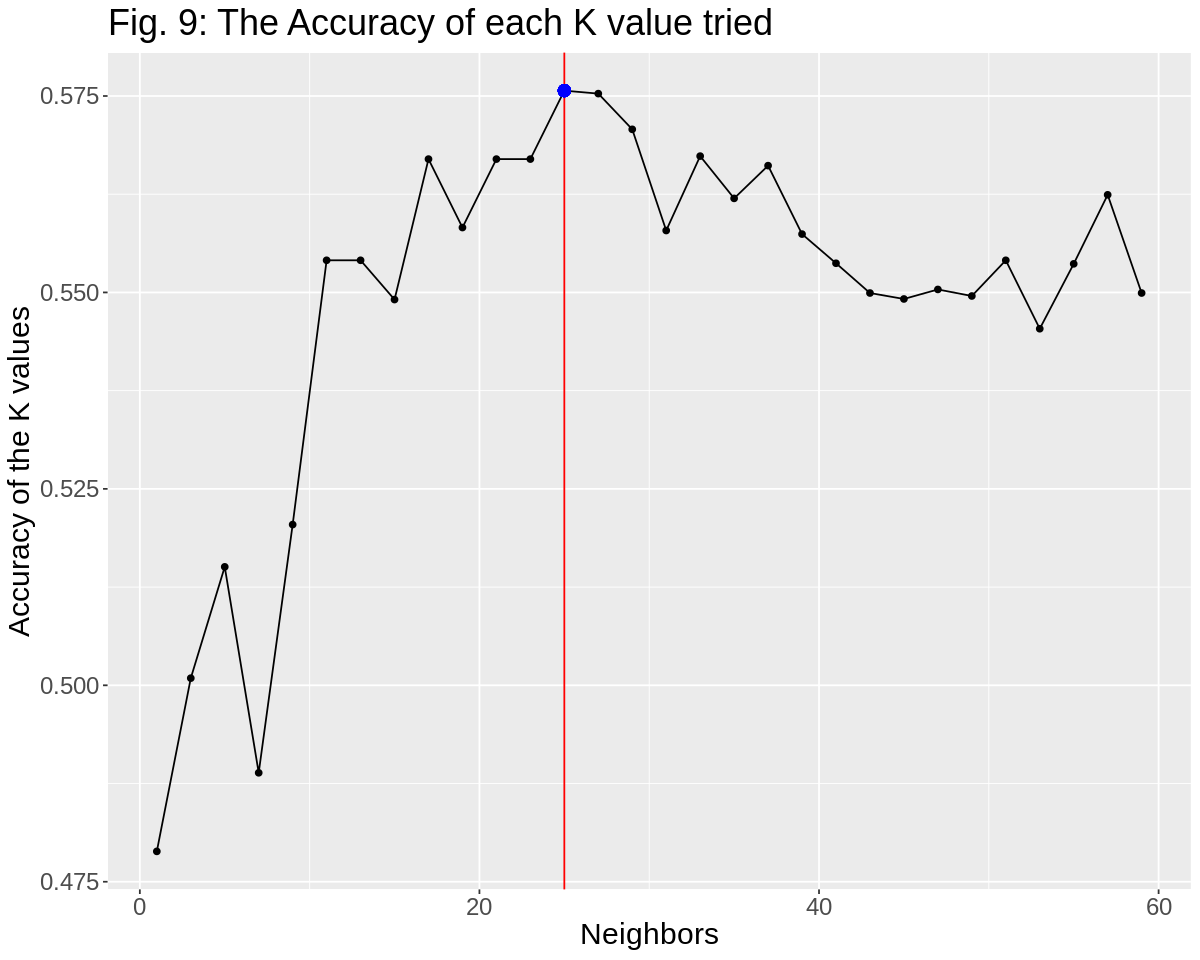

In [144]:
accuracy_of_k_exercise <- exercise_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy <- accuracy_of_k_exercise |>
                filter(neighbors == 25) |> 
                select(mean) |>
                pull()

accuracy_plot_exercise <- accuracy_of_k_exercise |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 25, colour = "red") +
                    geom_point(aes(x = 25, y = highest_accuracy), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 9: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 18))

accuracy_plot_exercise

From the above plot, we will choose $K$ = 25 to build this model. This is because this $K$ generates the highest accuracy, while still having the $K$ values adjacent to it being relatively accurate as well.

With an accurate K selected, we can now build a model that employs and it, and fit this model to the training data to train it. We use this to make predictions on the testing data.

In [145]:
set.seed(9999)

# Creating a new model which includes the K to generate the best fit. 

best_exercise_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_exercise_fit <- workflow() |>
                        add_recipe(exercise_recipe) |>
                        add_model(best_exercise_model) |>
                        fit(data = balanced_exercise_train)

# Fitting the model to our testing data to make the predictions. 

exercise_predictions <- best_exercise_fit |>
                        predict(exercise_test) |>
                        bind_cols(exercise_test)

Through the analysis of the metrics and confusion matrix for this model we can dtermine how successful it was at predicting the classes within the testing data.

In [146]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

exercise_metrics <- exercise_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
exercise_metrics

exercise_conf_mat <- exercise_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
exercise_conf_mat

[1] 0.4545455

          Truth
Prediction  0  1  2  3  4
         0 30  4  1  1  0
         1  0  0  1  2  0
         2  6  6  5  3  0
         3  3  2  0  0  0
         4  3  3  3  4  0

<b>Table 6:</b> This exercise model has an accuracy of 0.52, indicating that approximately half of its predictions are correct. The confusion matrix shows that there are no data points with a result of 4 in the testing data.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



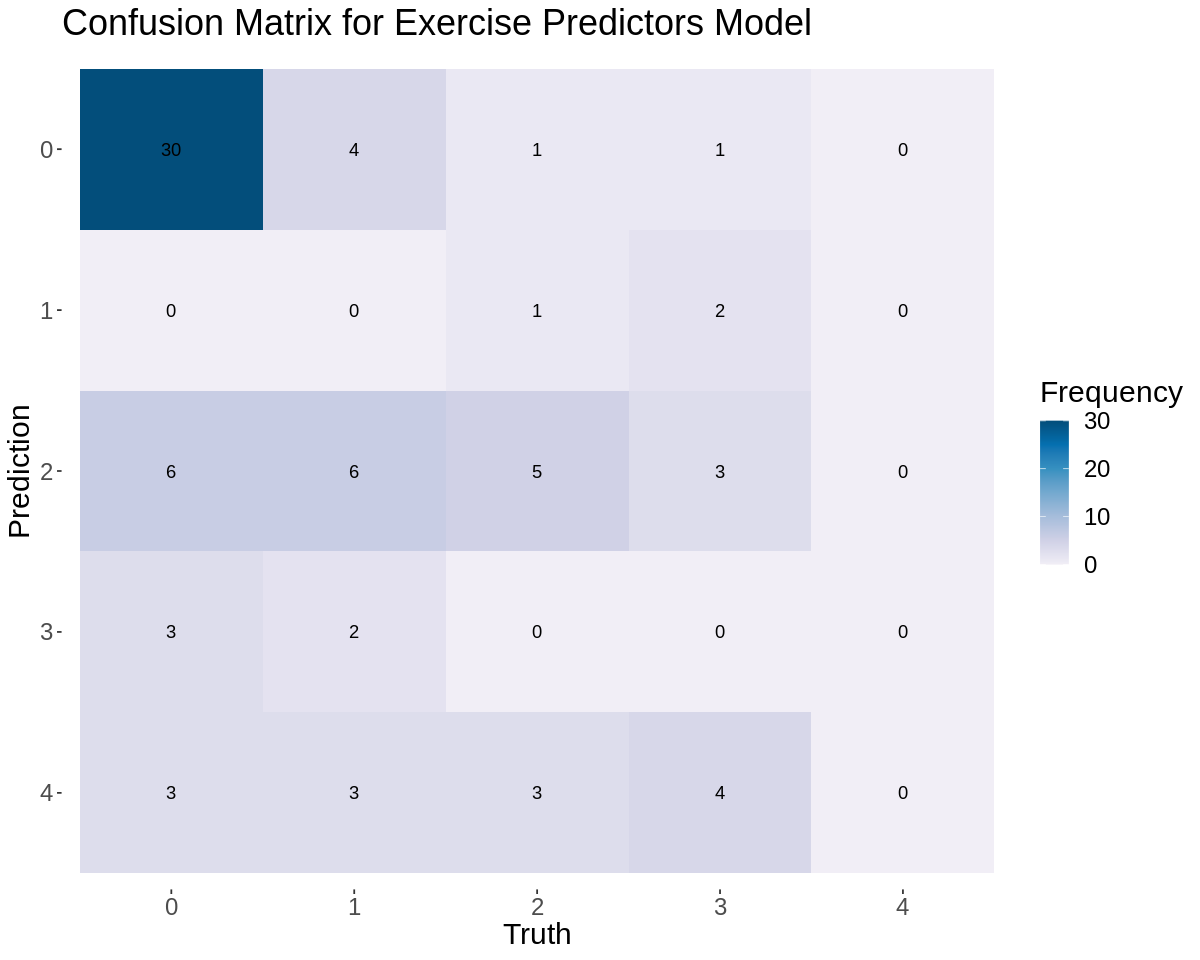

In [147]:
#visualizing the confusion matrix for the exercise predictors model

autoplot(exercise_conf_mat, type = "heatmap") +
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +       
    labs(title = "Confusion Matrix for Exercise Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 18),
          plot.caption = element_text(size = 16, hjust = 0))

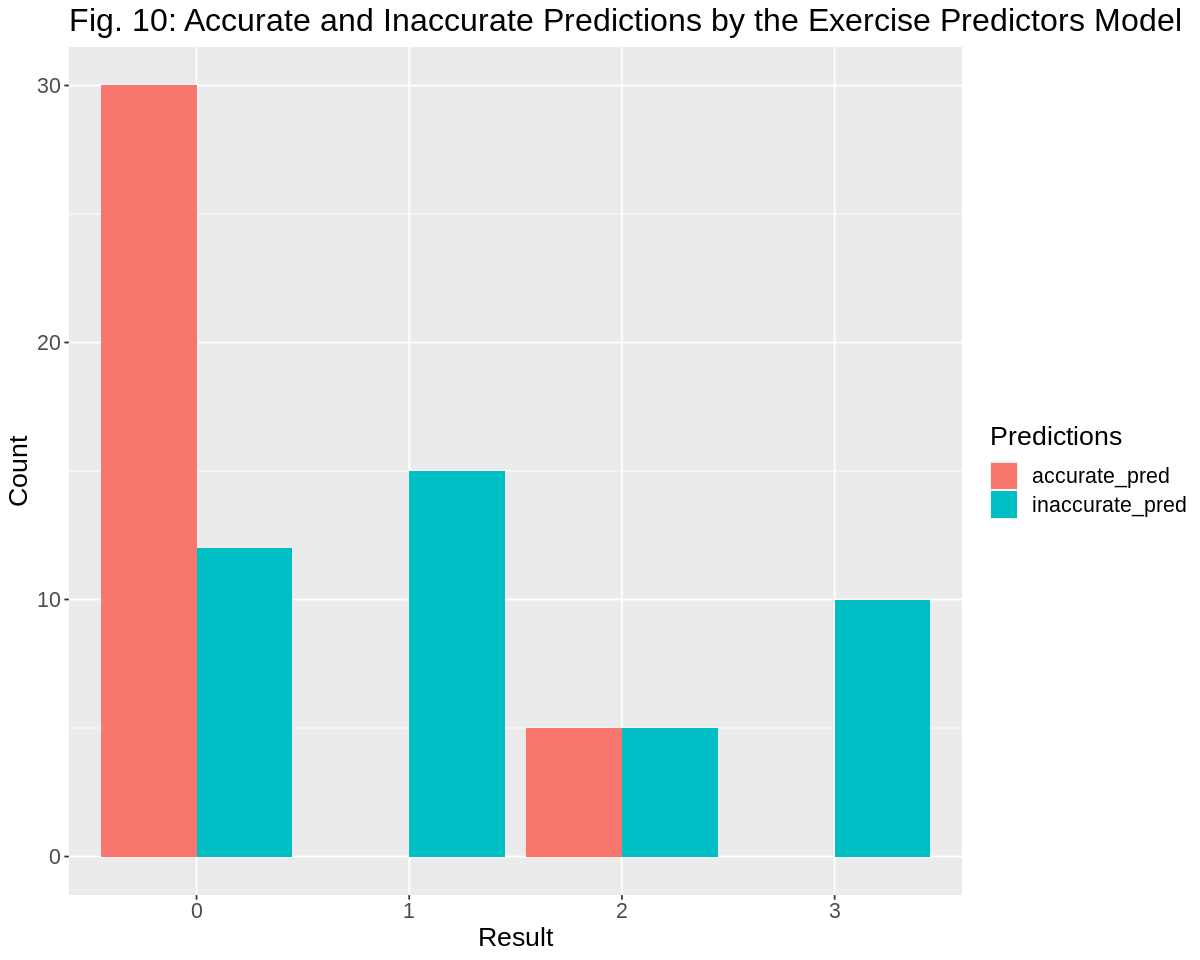

In [148]:
# Making a data frame from the confusion matrix data.
exercise_pred_accuracy <- exercise_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result))
    data_long <- reshape2::melt(exercise_pred_accuracy, id.vars = "result")

# Visualizing the confustion matrix as a bar graph. 
exercise_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 10: Accurate and Inaccurate Predictions by the Exercise Predictors Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

exercise_pred_accuracy_plot

This plot looks at the number of accurate predictions by this exercise model, compared to the number of inaccurate predictions. We see that, as was the case with the non-exercise predictor model, our model makes more inaccurate predictions with results 1- than it makes accurate predictions. With the absence of values with result of 4 in the testing data, we cannot determine the model's accuracy for that result. However, what is different from the non-exercise model is that this model makes more accurate than innacurate predictions when the result is 0. 



<b>References:</b>

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. British Journal of General Practice, 60(575), 246-257. 10.3399/bjgp10X502137

Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Harvard Health Publishing. (2021, September 21). Angina: Symptoms, diagnosis and treatments. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-andtreatments#:~:text=September%2021%2C%202021,by%20cholesterol%2Dclogged%20coronary%20arteries.

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. Heart. 90(12). 1417-1421. 10.1136/hrt.2003.031260

Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. PLoS ONE, 14(5), https://doi.org/10.1371/journal.pone.0216534

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine (Baltimore). 94(47). 10.1097/MD.0000000000002160
